# Load and glance 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/ai-generated-essays-dataset/AI Generated Essays Dataset.csv')

In [2]:
print(f"▶︎ Dataset shape: {df.shape}")
print("Column types & missing counts:")
print(df.dtypes.to_frame("dtype").join(df.isna().sum().to_frame("n_missing")))
print(df.dtypes.to_frame("dtype").join(df.isna().sum().to_frame("n_missing")))

print("▶︎ Sample rows:")
display(df.sample(3, random_state=42))



▶︎ Dataset shape: (1460, 2)
Column types & missing counts:
            dtype  n_missing
text       object          0
generated   int64          0
            dtype  n_missing
text       object          0
generated   int64          0
▶︎ Sample rows:


,text,generated
892,The most basic and persistent form of transpor...,0
1105,Many people are not in favor of keeping the El...,0
413,"Dear State Senator, The Electoral College is a...",0


In [3]:
label_counts = df["text"].value_counts().rename_axis("text").reset_index(name="count")
label_counts["pct"] = 100 * label_counts["count"] / label_counts["count"].sum()
print("▶︎ Label distribution:")
display(label_counts)

▶︎ Label distribution:


,text,count,pct
0,"""The evolution of artificial intelligence (AI)...",2,0.136986
1,"Machine learning, a subset of artificial intel...",1,0.068493
2,Cars most people use them for transportation. ...,1,0.068493
3,"Limiting car usage has many advantages, from s...",1,0.068493
4,For many years people have been using cars to ...,1,0.068493
...,...,...,...
1454,"Imagine the world in the future, completely fu...",1,0.068493
1455,Dear every state senator of the United States ...,1,0.068493
1456,"Richard Nixon, Jimmy Carter, and Bob Dole are ...",1,0.068493
1457,When you think about limiting car usage you mi...,1,0.068493


In [4]:
# ------ SAMPLE DATA FOR SPEED -------- #
SAMPLE_SIZE = 3000  # You can lower or raise this
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=2024).reset_index(drop=True)

In [5]:
# ------ LABEL DISTRIBUTION ON ALL DATA (for accuracy) -------- #
label_counts = df["text"].value_counts().sort_index().reset_index()
label_counts.columns = ["text", "count"]
label_counts["pct"] = (100 * label_counts["count"] / label_counts["count"].sum()).round(2)
print("▶︎ Label distribution:")
display(label_counts)

▶︎ Label distribution:


,text,count,pct
0,""" All of our development since World War 2 has...",1,0.07
1,""" The Electoral College is a process, not a pl...",1,0.07
2,""" What's wrong with the Electoral College?"" To...",1,0.07
3,"""Abolish the electoral college!"" is a famous s...",1,0.07
4,"""All of our development since World War II has...",1,0.07
...,...,...,...
1454,"out with the old and in with the new. ""The Ele...",1,0.07
1455,studies have shown that passenger cars are res...,1,0.07
1456,there are many thing in life people want and n...,1,0.07
1457,transportation has been a key part of many soc...,1,0.07


In [6]:
# Simple count of 0s and 1s in the 'generated' column:
print(df['generated'].value_counts())

human_count = (df['generated'] == 0).sum()
ai_count = (df['generated'] == 1).sum()
print(f"Human-written:   {human_count}")
print(f"AI-generated:    {ai_count}")

generated
0    1375
1      85
Name: count, dtype: int64
Human-written:   1375
AI-generated:    85


In [7]:
print(df.isnull().sum())


text         0
generated    0
dtype: int64


# Fast world cloud

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

for label in [0, 1]:
    texts = df[df['generated'] == label]['text']
    n = min(100, len(texts))  # use up to 100 samples, or all if less
    sample_texts = texts.sample(n, random_state=1) if n > 0 else []
    if n == 0:
        print(f"No texts available for label {label}")
        continue

    cv = CountVectorizer(stop_words='english', max_features=10)
    cv.fit(sample_texts)
    words = cv.get_feature_names_out()
    freqs = cv.transform(sample_texts).sum(axis=0).A1
    print(f"Most common words in {'Human' if label==0 else 'AI'} texts (top 10):")
    for word, count in sorted(zip(words, freqs), key=lambda x: -x[1]):
        print(f"{word:>12s}: {count}")


Most common words in Human texts (top 10):
   electoral: 562
      people: 549
        vote: 511
     college: 446
         car: 391
        cars: 323
      states: 315
   president: 284
       votes: 232
    electors: 213
Most common words in AI texts (top 10):
          ai: 69
      energy: 62
     ethical: 56
  challenges: 46
  technology: 43
       world: 40
   potential: 38
      coffee: 37
      making: 34
      impact: 33


# classic ml models


In [9]:
from sklearn.model_selection import train_test_split

# Start from the same sampled DataFrame as before:
SAMPLE_SIZE = 3000
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)

X = df_sample['text']
y = df_sample['generated']

# Split stratified, as before
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Combine train features/labels for resampling
train_df = pd.DataFrame({'text': X_train, 'generated': y_train})

# Separate majority and minority classes
df_majority = train_df[train_df.generated == 0]
df_minority = train_df[train_df.generated == 1]

# Upsample minority class
df_minority_upsampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)

# Combine back to balanced training data
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# Shuffle the rows
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Final features and labels
X_train_bal = df_upsampled['text']
y_train_bal = df_upsampled['generated']


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train_bal)
X_test_tfidf = tfidf.transform(X_test)


In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train_bal)
y_pred = svm.predict(X_test_tfidf)

print("== SVM after Upsampling ==")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))


== SVM after Upsampling ==
Accuracy: 0.9965753424657534
F1-score:               precision    recall  f1-score   support

           0      0.996     1.000     0.998       275
           1      1.000     0.941     0.970        17

    accuracy                          0.997       292
   macro avg      0.998     0.971     0.984       292
weighted avg      0.997     0.997     0.997       292

Confusion Matrix: [[275   0]
 [  1  16]]


# Deep learning method in nlp

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

2025-08-07 15:08:54.349246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754579334.588704      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754579334.653327      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:

X = df['text'].astype(str)
y = df['generated'].astype(int)

# test split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [14]:
# 5. Tokenizer , Padding
VOCAB_SIZE = 10000
MAXLEN = 400

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)


In [15]:
# text to numbers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post', truncating='post')

In [16]:
# lstm 
model = Sequential([
    Embedding(VOCAB_SIZE, 64, input_length=MAXLEN),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-08-07 15:09:10.380444: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# 7. آموزش مدل
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=30,
    batch_size=32
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.8629 - loss: 0.5162 - val_accuracy: 0.9795 - val_loss: 0.0694
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9516 - loss: 0.1039 - val_accuracy: 0.9315 - val_loss: 0.0991
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9407 - loss: 0.1490 - val_accuracy: 0.9692 - val_loss: 0.1052
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9604 - loss: 0.0983 - val_accuracy: 0.9692 - val_loss: 0.0705
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9759 - loss: 0.0614 - val_accuracy: 0.9589 - val_loss: 0.0756
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9704 - loss: 0.0658 - val_accuracy: 0.9760 - val_loss: 0.0524
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9762 - loss: 0.0549 - val_accuracy: 0.9863 - val_loss: 0.0411
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9890 - loss: 0.0365 - val_accuracy: 0

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
Confusion Matrix: [[275   0]
 [  2  15]]
Classification Report:               precision    recall  f1-score   support

           0      0.993     1.000     0.996       275
           1      1.000     0.882     0.938        17

    accuracy                          0.993       292
   macro avg      0.996     0.941     0.967       292
weighted avg      0.993     0.993     0.993       292



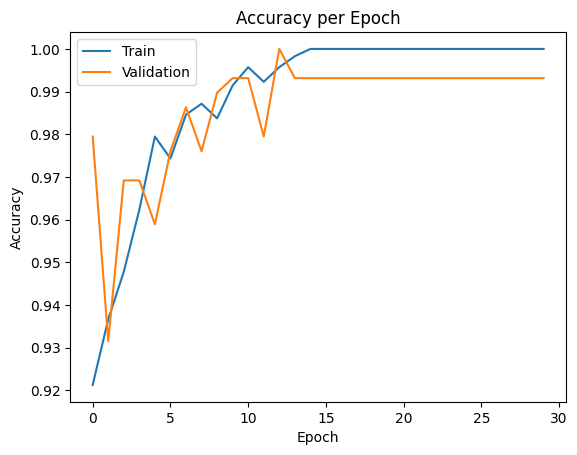

In [18]:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("Confusion Matrix:", confusion_matrix(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred, digits=3))

# 9. رسم نمودار آموزش
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()